#  Application of Neural Networks in Finance 
Even the most simple NN's can be useful. This notebook will demonstrate a simple approach for a predictive trading model. 

### This notebook does the following:
-Dynamically load daily price history from Yahoo / Google Finance 
<br/>-Apply some feature engineering
<br/>-Train  XGBoost and NN Models to predict if the direction of the next day's price move
<br/>-Re-Train based on the most important Feature Columns
<br/>-Predict using the trained models and evaluate the financial performance  

### Learn how to:
-Do Basic Feature Engineering in Pandas
<br/>-Use XGBoost to detect most important features
<br/>-Stop Training a Model when the metrics fail to improve, and re-set model  to what it was after the best epoch 
<br/>-Visualise Model input and outputs
<br/>-Plot loss and accuracy charts
<br/>-Plot some cool charts like Auto Correlation  &  Scatter Matrix
<br/>-Make Money applying NN to Finance !

In [1]:
import numpy as np
from datetime import datetime
import operator
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import legend
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, Dropout, Convolution2D, MaxPooling2D, LSTM
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.linear_model import LinearRegression
from keras.utils import np_utils
import itertools
import copy
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas_datareader as pdr
from IPython import display


/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5105)
/home/icarus/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Global Settings & Variables

In [2]:
useGoogle = True        # Use either Google or Yahoo Finance
#rates                  # DataFrame of Raw price data 
INST='^GSPC'            # Financial Instrument Code  eg IBM, F, FB  
useLSTM=False           # Use the LSTM model instead of the Dense NN
plotall=True            # Display all the Charts
epochs=1000             # Max number of epochs to run
waitEpochs=100          # Max number of epochs to wait for an improvement before stopping training
#AA                     # feature engineered DataFrame
#x, xi, xt              # np arrays for x, xi is the train set, xt is the test set  
#y, yi, yt              # np arrays for y, yi is the train set, yt is the test set
#split                  # array index the separates the train from test sets
#inputCols              # list of columns from AA that will be used to build x
#m                      # current model
#window=0               # LSTM window
#offset=0               # Ignore the first n rows of x
#posVect                # position predictions 1="LONG"  -1 = "SHORT"              
#predictions            # raw model predictions
#pnlVect                # profit & loss vector

##   Data Load & Inspection Functions

In [3]:
def GetData():
    global rates
    start = datetime(1990, 1, 1)
    end = datetime.now()
    if useGoogle:
        rates= pdr.get_data_google(INST, start, end)
        rates['Adj Close']=rates['Close']           #### Note Google does not have adj price for corporate actions
    else:
        rates= pdr.get_data_yahoo(INST, start, end)
    rates.rename(columns={'Open': 'OPEN', 'High': 'HIGH', 'Low': 'LOW', 'Adj Close': 'CLOSE'}, inplace=True)
    rates['Volume'].fillna(0, inplace=True)
    rates = rates.reset_index()

In [4]:
def Start(inst):  
    global INST
    INST=inst
    GetData()
    if plotall :
        fig, ax = plt.subplots(1,1) 
        ax.plot(rates['Date'],rates['CLOSE'])
        ax.set_title(inst)
        plt.show()

In [5]:
def PlotAutoCorrel():
    fig = plt.figure()
    _ = autocorrelation_plot(rates['CLOSE'], label=INST)
    plt.show()
    print "Describing " + INST
    display.display(rates.describe())

## Feature Engineering  Functions

In [6]:
def divMax(data,column):    # scale 
    data[column]=data[column]/max(data[column])   

def mavg(data,column,periods): #  moving average
    c=pd.Series.rolling(data[column],periods).mean()
    data[column+"mavg"+str(periods)]=c        
    
def logColumn(data,column):  # log
    data[column]=np.log(data[column]) 
    
def pct(data,column):         # % change 
        data[column+"pct"]=((data[column]-data[column].shift())/data[column])

def mom(data,column,MomPeriodOffset):   # Momentum 
    x=data[column].as_matrix()
    res=np.zeros(len(data))
    for i in range(len(x)):
        if (i >(MomPeriodOffset-1)):                
            iqr = np.subtract(*np.percentile(x[(i-3):i], [75, 25]))                                             
            if (iqr<=0.000000001):
                res[i]=0.0
            else:
                res[i]=(x[i]-x[i-MomPeriodOffset])/ iqr #np.std(x[i-3:i]) # todo divide by interquartile to avoid large and small values 
    data[column+"mom"+str(MomPeriodOffset)]=res

def bolWidth(data,column,windowsize):    # Bollenger Band Width 
    x=data[column].as_matrix()
    res=np.zeros(len(data))
    for i in range(len(x)):
        if (i >windowsize):
            std=np.std(x[i-windowsize-1:i])
            mean=np.mean(x[i-windowsize-1:i])
            bolup=mean+2*std
            boldown=mean-2*std
            bolwidth=(bolup-boldown)/mean
            res[i]=bolwidth
    data[column+"bolW"+str(windowsize)]=res
    
def TR (data):  #  True Range
    h=data['HIGH'].as_matrix()
    l=data['LOW'].as_matrix()
    pc=data['CLOSE'].as_matrix()
    res=np.zeros(len(data))
    for i in range(len(h)):
        if (i >1): 
            t=[(h[i]-l[i]),abs((h[i]-pc[i-1])),abs((l[i]-pc[i-1])) ]

            res[i]=np.amax(t)
    data['TR']=res

def ATR(data, window):   # Average True Range
    c=data['TR'].ewm(span = window, min_periods = window).mean()
    data["ATR"+str(window)]=c
    

In [7]:
def LR(y):   # Linear Regression
    X = np.matrix(range(len(y))).T
    m = LinearRegression()
    m.fit(X, y)
    p=np.array([len(y)]).reshape(-1,1)
    return m.predict(p)

def TSF(data,column, window):
    x=data[column].as_matrix()
    res=np.zeros(len(data))
    for i in range(len(data)):
        if (i>window):
            res[i]=LR(x[i-(window-1):i])
    data["TSF"+str(window)]=res
     

In [8]:
def norm(data,column,window):   # rolling normalisation function
    x=data[column].as_matrix()
    res=np.zeros(len(data))
    x[np.isnan(x)] = 0
    for i in range(len(data)):
        if (i>window):
            sub=x[i-window:i]
            avg=np.mean(sub)
            ma=np.amax(sub)
            mi=np.amin(sub)
            res[i]=(x[i]-avg)/(ma-mi)
            #res[i]=(x[i]-avg)/np.std(sub)
    data[column]=res

In [9]:
def objective(data):           # used if we want have a regressor rather than a classifier 
    x=data['CLOSE'].as_matrix()
    x2=data['ATR100'].as_matrix()
    res=np.zeros(len(data))
    for i in range(len(data)):
        if( i<len(x)-1):
            res[i]=(x[i+1]-x[i])/x2[i+1] 
    data['objective']= res

In [10]:
def Except(full_list, excludes):    # list "except"  function
    s = set(excludes)
    return (x for x in full_list if x not in s)

In [11]:
def PrepData(XColumns=""):
    global AA
    global split
    global inputCols
    AA=rates.copy()  
    pct(AA,'CLOSE')
    norm(AA,'CLOSE',100)
    norm(AA,'OPEN',100)
    norm(AA,'HIGH',100)
    norm(AA,'LOW',100)
    mom(AA,'CLOSE',3)
    mom(AA,'CLOSE',5)
    mom(AA,'CLOSE',10) 
    mom(AA,'CLOSE',30)     
    mom(AA,'CLOSE',100)
    TR(AA)     
    ATR(AA, 7)   
    ATR(AA, 10)   
    ATR(AA, 20)   
    ATR(AA, 100)   
    bolWidth(AA,'CLOSE',20)
    TSF(AA,'CLOSE',10)
    mavg(AA,'CLOSE',10)
    mavg(AA,'CLOSE',30)
    mavg(AA,'CLOSE',100)
    mavg(AA,'CLOSE',200)
    AA=AA.loc[200:,] # drop the first 200 rows
    AA.reset_index(drop=True, inplace=True)
    AA['ATR10v20']=AA['ATR10'] / AA['ATR20']
    AA['ATR10v100']=AA['ATR10']/AA['ATR100']
    AA['DeltaBolW20']= AA['CLOSEbolW20'].diff()
    if XColumns=="":  # use the default columns except Date and Closepct
        inputCols=list(Except(AA.columns.tolist(),['Date', 'CLOSEpct' ] ))# dont normalize the date and pct CLOSE columns
    else:
        inputCols = XColumns
    for c in Except(inputCols,['OPEN', 'HIGH', 'LOW','CLOSE' ] ): 
        norm(AA,c,200)
    objective(AA)   # add the objective column
    AA.reset_index(drop=True, inplace=True)
    split= int(len(AA)*.8)

In [12]:
def PlotAutoCorrelAfter():
    tmp=AA['CLOSE']
    tmp=tmp[201:]
    plt.plot(tmp)
    plt.show()
    _ = autocorrelation_plot(tmp, label=INST)
    plt.show()

## Use XGBoost to Evaluate Feature Importance 

In [13]:
def GetFeatureImportance(): 
    model = XGBClassifier()
    x=AA[inputCols]
    y=np.sign(AA['CLOSEpct'].shift(-1)) # set Y to be  tomorrow's close px  0 for down 1 for up 
    y[y<0]=0
    xi=x.loc[:split]
    yi=y.loc[:split]
    model.fit(xi, yi)
    featureImp = model.feature_importances_
    if plotall:
        xgb.plot_importance(model)
        plt.show()
    preds=model.predict(x.loc[split:(len(y)-2)])
    print "XGBoost Accuracy is : " + str(accuracy_score(preds,y.loc[split:(len(y)-2)].as_matrix()))
    return featureImp

## Deep Learning Woohoo ! 

In [14]:
def MakeModel(cols):     #number of cols 
    model = Sequential()
    model.add(Dense(cols, input_dim=cols, kernel_initializer="normal", activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer="normal", activation='sigmoid')) #
    optimizer = RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [15]:
def MakeLSTMModel(window, cols):
    model = Sequential()
    model.add(LSTM(100, input_shape=( window, cols)))   
    model.add(Dense(1, kernel_initializer="normal",  activation='sigmoid')) #
    optimizer = RMSprop(lr=0.001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

In [16]:
def TrainModel(cols):
    global yt
    global xt
    global x
    global y
    x=AA[inputCols].as_matrix()
    y=np.sign(AA['CLOSEpct'].shift(-1).as_matrix()) # set Y to be  tomorrow's close price change  0 for down 1 for up 
    y[y<0]=0
    filepath="weights-improvement.hdf5"
    if useLSTM:
        #x, y = SetLSTMInputs()
        x=np.reshape(x, (x.shape[0], 1, x.shape[1])) # add another dimension
        m=MakeLSTMModel(window, cols)
    else:
        m =MakeModel(cols)
    xi=x[201:split]     
    xt=x[split:len(x)-2]     
    yi=y[201:split]   
    yt=y[split:len(y)-2]    
    checkpoints = [ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max'),
                   EarlyStopping(monitor='val_acc', patience=waitEpochs, verbose=0)
                  ]    
    hist = m.fit(xi,yi,
            validation_data =(xt,yt),     
            epochs=epochs,
            verbose=0,
            callbacks=checkpoints
            )
    m.load_weights(filepath)
    return m, hist 

### Helper  Functions 

In [17]:
def SetLSTMInputs():
    samps=len(x)-offset
    xn=[]
    yn=[]
    for i in range (samps):
        xn.append (x[(offset-window)+i:offset+i])
        yn.append (y[offset+i])    
    return np.array(xn) , np.array(yn)    

In [18]:
def GetNNAccuracy(history):
    global predictions
    predictions=m.predict(xt)
    if plotall:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    ytmp=np.expand_dims(yt, axis=1)
    for i in [0 , 0.05, 0.1, 0.2, 0.3, 0.4 ]:
        print "" 
        print "Signal Threshold " + str(i)
        idxs=np.any([predictions > (0.5+i), predictions < (0.5-i)], axis=0)
        preds= predictions[idxs]
        print "Matching Rows " + str(len(preds))
        preds[preds>0.5]=1
        preds[preds<0.5]=0
        print "NN Accuracy " + str (accuracy_score(preds,ytmp[idxs]) )   

In [19]:
def CheckPerformance(preds, thresh, holdPrevPos=True):
    period=len(preds)
    global posVect
    global predictions
    global pnlVect
    predictions=preds
    pnlVect=np.zeros(period)
    posVect=np.zeros(period)
    for i in range(period):
        if preds[i]>(0.5+thresh):
                posVect[i] = 1
        if preds[i]<(0.5-thresh):
                posVect[i] = -1
        if posVect[i]==0:
            if holdPrevPos:
                posVect[i]=posVect[i-1]
            else:
                posVect[i]=0
        pnlVect[i]=posVect[i]*AA['CLOSEpct'].shift(-1)[offset+split+i]
    return  np.cumsum(pnlVect),posVect 

In [20]:
def ChartNNPerformance(thresh,  holdPrevPos=True):
    pnl, positions = CheckPerformance(predictions,thresh, holdPrevPos)
    plt.plot(pnl)
    plt.plot(np.cumsum(AA['CLOSEpct'][offset+split:]).shift(-1).as_matrix())
    legend(["Model perf"] + [INST + " perf"], loc=2)
    plt.show()

In [21]:
def ChartCrossCorrel():
    x=AA[inputCols]
    colv= [x[c]for c in x.columns]              
    colv =pd.concat(colv, axis=1)              
    _ = scatter_matrix(colv, figsize=(20, 20), diagonal='kde')
    plt.show()

In [22]:
def ExamineInputs():
    print "Charts for last 200 days"  
    print ""
    print "Input Colums"  
    print inputCols
    for c in inputCols:
        plt.plot(AA.tail(200)[c])
    plt.show()
    print "predicted positions"  
    plt.bar(range(200),posVect[-200:])
    plt.show()


### Functions to run the Analysis

In [23]:
def RunFullAnalysis(StockCode='^GSPC'):
    global m
    bestnCols=6
    Start(StockCode)
    if plotall:
        PlotAutoCorrel()
    PrepData()
    if plotall:
        PlotAutoCorrelAfter()
    featureImp = GetFeatureImportance()
    res = TrainModel(len(inputCols))
    m=res[0]
    GetNNAccuracy(res[1])
    ChartNNPerformance(0.0)
    dd ={}
    for i  in range(len(inputCols)):
        dd[inputCols[i]]=featureImp[i]
    
    dd = list(sorted(dd.items(), key=operator.itemgetter(1), reverse=True))
    MostImportantCols=[list(t)[0] for t in dd[:bestnCols]]
    print MostImportantCols
    #PrepData(MostImportantCols)
    if plotall:
        ChartCrossCorrel()
    #res = TrainModel(bestnCols)
    #m=res[0]    
    #print "Using Restricted Columns"
    #GetNNAccuracy(res[1])
    #ChartNNPerformance(0.0)

In [24]:
def RunSingleModelWithFixedColumns(StockCode, Columns):
    global m
    Start(StockCode)
    PrepData(Columns)
    res = TrainModel(len(Columns))
    m=res[0]
    GetNNAccuracy(res[1])
    ChartNNPerformance(0.0)

### Run Full Analysis

STOCKS TO TRY: NYSE:CAT,  IBM, MS , GS, NYSE: XOM

#### Dense

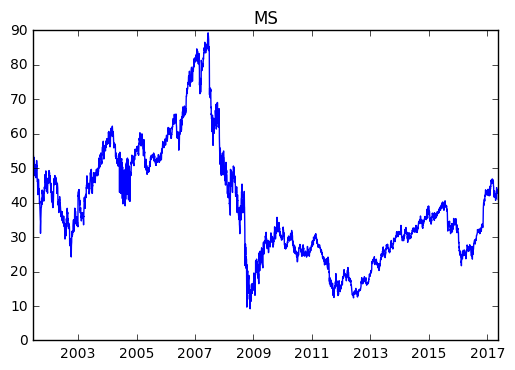

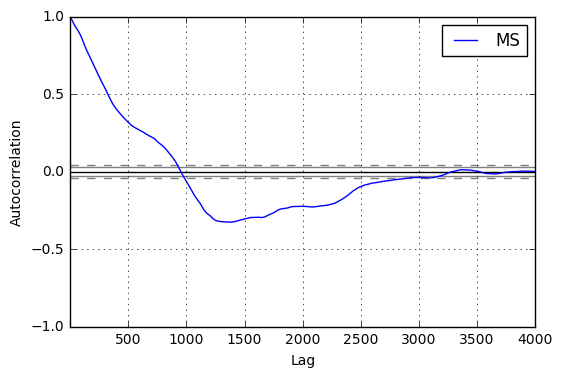

Describing MS


,OPEN,HIGH,LOW,Close,Volume,CLOSE
count,4000.000000,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000
mean,38.409865,39.608922,38.488277,39.054380,1.380478e+07,39.054380
std,16.193534,16.578974,16.363017,16.472419,1.461645e+07,16.472419
min,9.190000,10.210000,6.710000,9.200000,0.000000e+00,9.200000
25%,26.900000,27.285000,26.500000,26.987500,5.512069e+06,26.987500
50%,34.740000,35.875000,34.790000,35.325000,1.014215e+07,35.325000
75%,48.300000,51.030000,49.467500,50.262500,1.735135e+07,50.262500
max,90.770000,90.950000,88.330000,89.300000,3.297860e+08,89.300000


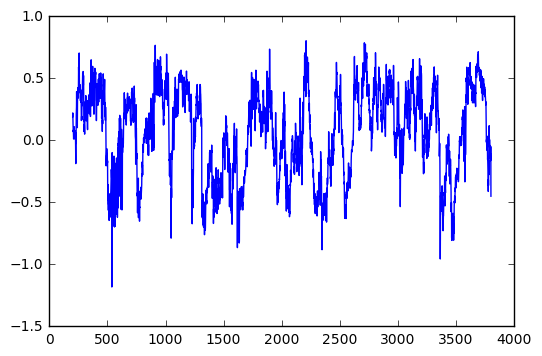

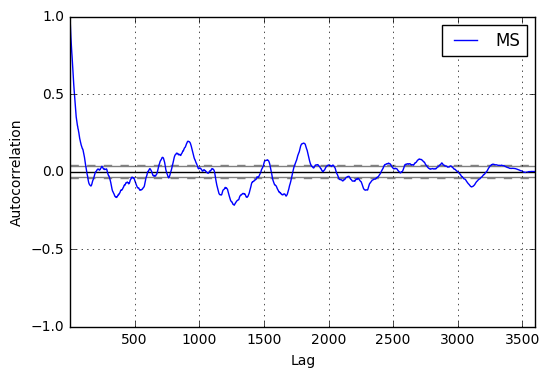

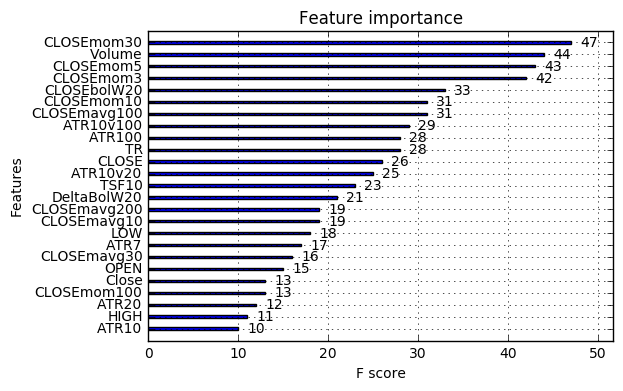

XGBoost Accuracy is : 0.486166007905


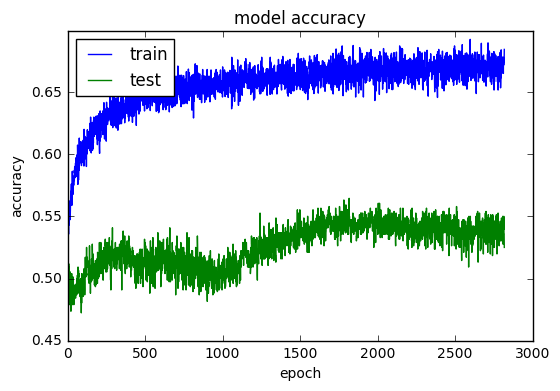

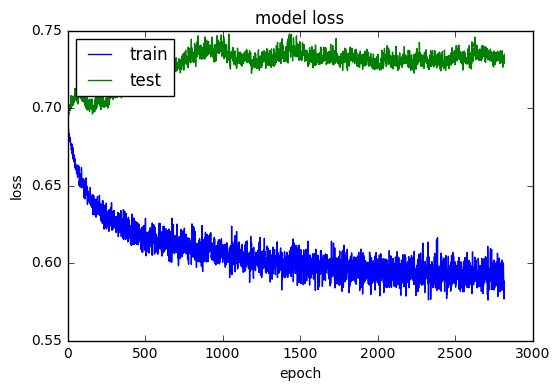


Signal Threshold 0
Matching Rows 758
NN Accuracy 0.564643799472

Signal Threshold 0.05
Matching Rows 306
NN Accuracy 0.545751633987

Signal Threshold 0.1
Matching Rows 143
NN Accuracy 0.531468531469

Signal Threshold 0.2
Matching Rows 51
NN Accuracy 0.529411764706

Signal Threshold 0.3
Matching Rows 32
NN Accuracy 0.46875

Signal Threshold 0.4
Matching Rows 17
NN Accuracy 0.470588235294


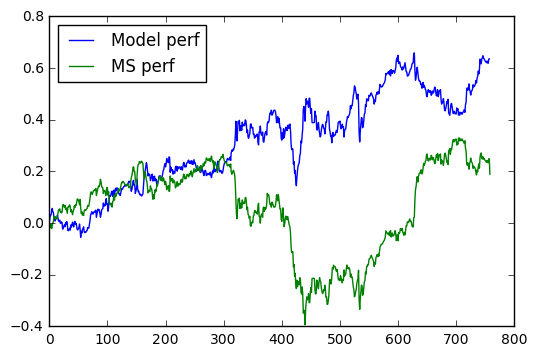

['CLOSEmom30', 'Volume', 'CLOSEmom5', 'CLOSEmom3', 'CLOSEbolW20', 'CLOSEmavg100']


KeyboardInterrupt: 

In [25]:
useLSTM=False           
plotall=False           
epochs=10            
waitEpochs=10  
window=0                
offset=0
RunFullAnalysis(StockCode='MS') # Dense network
ExamineInputs()

In [26]:
#ChartNNPerformance(0.005,True)

#### LSTM

In [27]:
#useLSTM=True          
#plotall=True          
#epochs=20             
#waitEpochs=10  
#window=1                
#offset=0
#RunFullAnalysis(StockCode='NYSE:CAT') 
#ExamineInputs()

### Fixed Set of Columns

#### Dense

In [28]:
#useLSTM=False           
#plotall=False           
#epochs=5000             
#waitEpochs=500  
#window=0                
#offset=0
#RunSingleModelWithFixedColumns(StockCode='NYSE:CAT', Columns=['ATR10v100', 'DeltaBolW20', 'TSF10', 'ATR7', 'CLOSEmom3', 'CLOSEmavg100']) 
#ExamineInputs()

#### LSTM

In [29]:
#useLSTM=True           
#plotall=True           
#epochs=200             
#waitEpochs=100  
#window=1                
#offset=0
#RunSingleModelWithFixedColumns(StockCode='NYSE:CAT', Columns=['CLOSEbolW20', 'CLOSEmom3', 'TSF10', 'ATR7', 'CLOSE']) 
#ExamineInputs()